In [5]:
import os
import random
import easydict
import requests
import torch
import numpy as np
import pandas as pd

from tqdm import tqdm
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [6]:
def generate_data_loader(file_path, tokenizer, args):

    def get_input_ids(data):
        document_bert = ["[CLS] " + str(s) + " [SEP]" for s in data]
        tokenized_texts = [tokenizer.tokenize(s) for s in tqdm(document_bert, "Tokenizing")]
        input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_texts, "Converting tokens to ids")]
        print("Padding sequences...")
        input_ids = pad_sequences(input_ids, maxlen=args.maxlen, dtype='long', truncating='post', padding='post')
        return input_ids

    def get_attention_masks(input_ids):
        attention_masks = []
        for seq in tqdm(input_ids, "Generating attention masks"):
            seq_mask = [float(i > 0) for i in seq]
            attention_masks.append(seq_mask)
        return attention_masks

    def get_data_loader(inputs, masks, labels, batch_size=args.batch):
        data = TensorDataset(torch.tensor(inputs), torch.tensor(masks), torch.tensor(labels))
        sampler = RandomSampler(data) if args.mode == 'train' else SequentialSampler(data)
        data_loader = DataLoader(data, sampler=sampler, batch_size=batch_size)
        return data_loader

    data_df = pd.read_csv(file_path)
    input_ids = get_input_ids(data_df['text'].values)
    attention_masks = get_attention_masks(input_ids)
    data_loader = get_data_loader(input_ids, attention_masks, data_df['label'].values if args.mode=='train' else [-1]*len(data_df))

    return data_loader

In [7]:
def save(model, dir_name):
    os.makedirs(dir_name, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(dir_name, 'model.pth'))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [8]:
def predict(model, args, data_loader):
    print('start predict')
    model.eval()

    eval_loss = []
    eval_accuracy = []
    logits = []

    for step, batch in tqdm(enumerate(data_loader)):
        batch = tuple(t.to(args.device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            if args.mode == 'test':
                outputs = model(b_input_ids, attention_mask=b_input_mask)
                logit = outputs[0]
            else:
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                loss, logit = outputs[:2]
                eval_loss.append(loss.item())

        logit = logit.detach().cpu().numpy()
        label = b_labels.cpu().numpy()

        logits.append(logit)

        if args.mode != 'test':
            accuracy = flat_accuracy(logit, label)
            eval_accuracy.append(accuracy)

    logits = np.vstack(logits)
    predict_labels = np.argmax(logits, axis=1)

    if args.mode == 'test':
        return predict_labels, None

    avg_eval_loss = np.mean(eval_loss)
    avg_eval_accuracy = np.mean(eval_accuracy)

    return predict_labels, avg_eval_loss, avg_eval_accuracy

In [9]:
def train(model, args, train_loader, valid_loader, patience=10):
    experiment_name = f"model_ckpt_{args.model_ckpt.replace('/', '_')}_lr_{args.lr}_batch_{args.batch}_epochs_{args.epochs}_maxlen_{args.maxlen}_eps_{args.eps}"
    writer = SummaryWriter(f'hai_kaggle/{experiment_name}')

    optimizer = AdamW(model.parameters(),
                      lr=args.lr,
                      eps=args.eps
                      )
    total_steps = len(train_loader) * args.epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=100,
                                                num_training_steps=total_steps)

    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    best_val_accuracy = 0.0
    best_train_accuracy = 0.0
    epochs_without_improvement = 0

    train_accuracies = []
    val_accuracies = []

    print('start training')
    for epoch in range(args.epochs):
        model.train()
        train_loss = []
        for step, batch in tqdm(enumerate(train_loader), f"training epoch {epoch}", total=len(train_loader)):
            model.zero_grad()
            batch = tuple(t.to(args.device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)
            loss = outputs[0]
            train_loss.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            writer.add_scalar('training loss',
                            loss.item(),
                            epoch * len(train_loader) + step)

        avg_train_loss = np.mean(train_loss)
        _, _, avg_train_accuracy = predict(model, args, train_loader)
        _, _, avg_val_accuracy = predict(model, args, valid_loader)
        print("Epoch {0},  Average training loss: {1:.4f} , Train accuracy : {2:.4f}, Validation accuracy : {3:.4f}"
              .format(epoch, avg_train_loss, avg_train_accuracy, avg_val_accuracy))

        train_accuracies.append(avg_train_accuracy)
        val_accuracies.append(avg_val_accuracy)

        writer.add_scalar('training accuracy',
                        avg_train_accuracy,
                        epoch)
        writer.add_scalar('validation accuracy',
                        avg_val_accuracy,
                        epoch)

        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            best_train_accuracy = avg_train_accuracy
            epochs_without_improvement = 0
            save_path = f"./saved_checkpoints/best_model/{experiment_name}_TrainAcc_{best_train_accuracy}_ValAcc_{best_val_accuracy}"
            save(model, save_path)
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"[Early Stopping]{patience} epoch에서 중단.[Early Stopping]")
            break

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epoch + 2), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epoch + 2), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    model_path = f"./saved_checkpoints/best_model/{experiment_name}_TrainAcc_{best_train_accuracy}_ValAcc_{best_val_accuracy}/model.pth"
    model.load_state_dict(torch.load(model_path))

    print(f"Best Train Accuracy: {best_train_accuracy}, Best Validation Accuracy: {best_val_accuracy}")

    writer.add_hparams({
        'lr': args.lr,
        'eps': args.eps,
        'batch': args.batch,
        'epochs': args.epochs,
        'maxlen': args.maxlen
        }, {
        'best_train_accuracy': best_train_accuracy,
        'best_val_accuracy': best_val_accuracy
        })

    writer.close()
    return model, best_train_accuracy, best_val_accuracy, train_accuracies, val_accuracies

In [10]:
def train_valid(args):
    if torch.cuda.is_available():
        args.device = 'cuda'
    else:
        args.device = 'cpu'

    model = AutoModelForSequenceClassification.from_pretrained(args.model_ckpt, num_labels=3)
    model.to(args.device)
    tokenizer = AutoTokenizer.from_pretrained(args.model_ckpt)

    train_dataloader = generate_data_loader(args.train_path, tokenizer, args)
    validation_dataloader = generate_data_loader(args.valid_path, tokenizer, args)

    model, best_train_accuracy, best_val_accuracy, train_accuracies, val_accuracies = train(model, args, train_dataloader, validation_dataloader)

    return model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy

In [11]:
# best_train_accuracy & best_val_accuracy는 모델 경로 때문에 주는 것임!
def test(model, tokenizer, test_args, file_path, args, best_train_accuracy, best_val_accuracy):
    if torch.cuda.is_available():
        test_args.device = 'cuda'

    test_dataloader = generate_data_loader(file_path, tokenizer=tokenizer, args=test_args)
    labels, _ = predict(model, test_args, test_dataloader)

    submit_df = pd.DataFrame()
    submit_df["idx"] = range(len(labels))
    submit_df["label"] = labels
    save_path = f"./saved_checkpoints/best_model/model_ckpt_{args.model_ckpt.replace('/', '_')}_lr_{args.lr}_batch_{args.batch}_epochs_{args.epochs}_maxlen_{args.maxlen}_eps_{args.eps}_TrainAcc_{best_train_accuracy}_ValAcc_{best_val_accuracy}/submission.csv"
    submit_df.to_csv(save_path, index=False)
    print(f"Submission file saved to {save_path}")

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 269044.94it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 305765.92it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 202604.27it/s]


start training


training epoch 0: 100%|█████████████████████| 2981/2981 [01:35<00:00, 31.15it/s]


start predict


2981it [00:29, 100.54it/s]


start predict


16it [00:00, 106.69it/s]


Epoch 0,  Average training loss: 0.3127 , Train accuracy : 0.9357, Validation accuracy : 0.9103


training epoch 1: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.90it/s]


start predict


2981it [00:29, 100.06it/s]


start predict


16it [00:00, 106.28it/s]


Epoch 1,  Average training loss: 0.2030 , Train accuracy : 0.9497, Validation accuracy : 0.9259


training epoch 2: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.87it/s]


start predict


2981it [00:29, 100.00it/s]


start predict


16it [00:00, 106.01it/s]


Epoch 2,  Average training loss: 0.1713 , Train accuracy : 0.9586, Validation accuracy : 0.9278


training epoch 3: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.77it/s]


start predict


2981it [00:29, 100.00it/s]


start predict


16it [00:00, 105.68it/s]


Epoch 3,  Average training loss: 0.1475 , Train accuracy : 0.9666, Validation accuracy : 0.9250


training epoch 4: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.75it/s]


start predict


2981it [00:29, 99.97it/s] 


start predict


16it [00:00, 106.02it/s]


Epoch 4,  Average training loss: 0.1280 , Train accuracy : 0.9738, Validation accuracy : 0.9268


training epoch 5: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.78it/s]


start predict


2981it [00:29, 99.96it/s] 


start predict


16it [00:00, 105.23it/s]


Epoch 5,  Average training loss: 0.1126 , Train accuracy : 0.9793, Validation accuracy : 0.9210


training epoch 6: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.81it/s]


start predict


2981it [00:29, 99.95it/s] 


start predict


16it [00:00, 105.12it/s]


Epoch 6,  Average training loss: 0.0994 , Train accuracy : 0.9836, Validation accuracy : 0.9229


training epoch 7: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.75it/s]


start predict


2981it [00:29, 99.98it/s] 


start predict


16it [00:00, 105.95it/s]


Epoch 7,  Average training loss: 0.0887 , Train accuracy : 0.9878, Validation accuracy : 0.9249
[Early Stopping]5 epoch에서 중단.[Early Stopping]


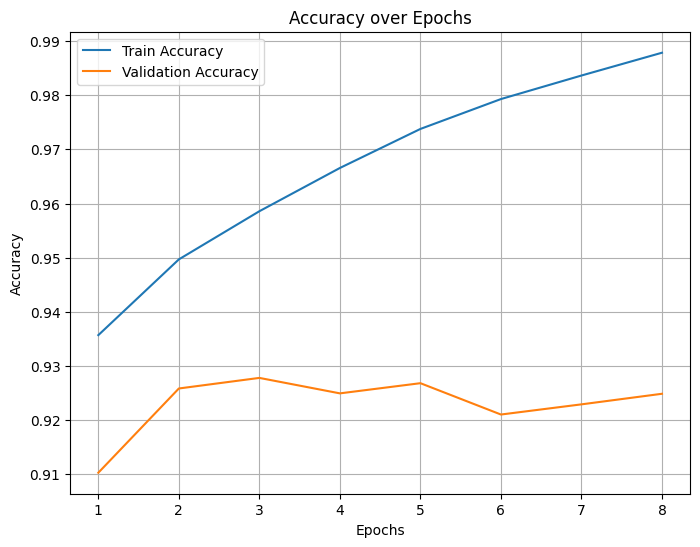

Best Train Accuracy: 0.9585751425696074, Best Validation Accuracy: 0.9278094951923077


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 299115.32it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 626/626 [00:00<00:00, 216422.21it/s]


start predict


10it [00:00, 105.87it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_monologg_koelectra-small-v3-discriminator_lr_5e-05_batch_64_epochs_50_maxlen_32_eps_1e-08_TrainAcc_0.9585751425696074_ValAcc_0.9278094951923077/submission.csv


In [8]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 64,
    "maxlen" : 32,
    "lr" : 5e-5,
    "eps" : 1e-8,
    "epochs" : 50,
    "model_ckpt" : "monologg/koelectra-small-v3-discriminator",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 64,
  "maxlen" : 32,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 274574.17it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 330878.69it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 208153.51it/s]


start training


training epoch 0: 100%|█████████████████████| 2981/2981 [01:34<00:00, 31.47it/s]


start predict


2981it [00:28, 103.02it/s]


start predict


16it [00:00, 109.04it/s]


Epoch 0,  Average training loss: 0.4820 , Train accuracy : 0.9115, Validation accuracy : 0.9025


training epoch 1: 100%|█████████████████████| 2981/2981 [01:35<00:00, 31.15it/s]


start predict


2981it [00:29, 102.19it/s]


start predict


16it [00:00, 108.57it/s]


Epoch 1,  Average training loss: 0.2671 , Train accuracy : 0.9284, Validation accuracy : 0.9161


training epoch 2: 100%|█████████████████████| 2981/2981 [01:36<00:00, 31.01it/s]


start predict


2981it [00:29, 102.30it/s]


start predict


16it [00:00, 109.05it/s]


Epoch 2,  Average training loss: 0.2306 , Train accuracy : 0.9347, Validation accuracy : 0.9141


training epoch 3: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.91it/s]


start predict


2981it [00:29, 101.70it/s]


start predict


16it [00:00, 107.32it/s]


Epoch 3,  Average training loss: 0.2099 , Train accuracy : 0.9401, Validation accuracy : 0.9152


training epoch 4: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.83it/s]


start predict


2981it [00:29, 101.87it/s]


start predict


16it [00:00, 108.09it/s]


Epoch 4,  Average training loss: 0.1953 , Train accuracy : 0.9454, Validation accuracy : 0.9171


training epoch 5: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.84it/s]


start predict


2981it [00:29, 101.48it/s]


start predict


16it [00:00, 108.27it/s]


Epoch 5,  Average training loss: 0.1838 , Train accuracy : 0.9492, Validation accuracy : 0.9123


training epoch 6: 100%|█████████████████████| 2981/2981 [01:37<00:00, 30.73it/s]


start predict


2981it [00:29, 101.69it/s]


start predict


16it [00:00, 108.40it/s]


Epoch 6,  Average training loss: 0.1734 , Train accuracy : 0.9538, Validation accuracy : 0.9162


training epoch 7: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.85it/s]


start predict


2981it [00:29, 101.83it/s]


start predict


16it [00:00, 108.65it/s]


Epoch 7,  Average training loss: 0.1650 , Train accuracy : 0.9571, Validation accuracy : 0.9277


training epoch 8: 100%|█████████████████████| 2981/2981 [01:36<00:00, 31.01it/s]


start predict


2981it [00:29, 102.33it/s]


start predict


16it [00:00, 108.02it/s]


Epoch 8,  Average training loss: 0.1570 , Train accuracy : 0.9600, Validation accuracy : 0.9278


training epoch 9: 100%|█████████████████████| 2981/2981 [01:36<00:00, 31.03it/s]


start predict


2981it [00:29, 102.20it/s]


start predict


16it [00:00, 108.18it/s]


Epoch 9,  Average training loss: 0.1507 , Train accuracy : 0.9619, Validation accuracy : 0.9287


training epoch 10: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.07it/s]


start predict


2981it [00:29, 102.37it/s]


start predict


16it [00:00, 108.00it/s]


Epoch 10,  Average training loss: 0.1426 , Train accuracy : 0.9646, Validation accuracy : 0.9239


training epoch 11: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.07it/s]


start predict


2981it [00:29, 102.35it/s]


start predict


16it [00:00, 108.93it/s]


Epoch 11,  Average training loss: 0.1368 , Train accuracy : 0.9665, Validation accuracy : 0.9326


training epoch 12: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.08it/s]


start predict


2981it [00:29, 102.33it/s]


start predict


16it [00:00, 108.98it/s]


Epoch 12,  Average training loss: 0.1300 , Train accuracy : 0.9688, Validation accuracy : 0.9240


training epoch 13: 100%|████████████████████| 2981/2981 [01:36<00:00, 31.03it/s]


start predict


2981it [00:29, 102.37it/s]


start predict


16it [00:00, 108.65it/s]


Epoch 13,  Average training loss: 0.1246 , Train accuracy : 0.9724, Validation accuracy : 0.9201


training epoch 14: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.10it/s]


start predict


2981it [00:29, 102.55it/s]


start predict


16it [00:00, 108.94it/s]


Epoch 14,  Average training loss: 0.1214 , Train accuracy : 0.9744, Validation accuracy : 0.9346


training epoch 15: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.11it/s]


start predict


2981it [00:29, 102.48it/s]


start predict


16it [00:00, 108.94it/s]


Epoch 15,  Average training loss: 0.1163 , Train accuracy : 0.9756, Validation accuracy : 0.9316


training epoch 16: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.14it/s]


start predict


2981it [00:29, 102.50it/s]


start predict


16it [00:00, 108.84it/s]


Epoch 16,  Average training loss: 0.1128 , Train accuracy : 0.9778, Validation accuracy : 0.9307


training epoch 17: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.12it/s]


start predict


2981it [00:29, 102.42it/s]


start predict


16it [00:00, 108.98it/s]


Epoch 17,  Average training loss: 0.1070 , Train accuracy : 0.9790, Validation accuracy : 0.9288


training epoch 18: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.13it/s]


start predict


2981it [00:29, 102.52it/s]


start predict


16it [00:00, 108.90it/s]


Epoch 18,  Average training loss: 0.1028 , Train accuracy : 0.9809, Validation accuracy : 0.9259


training epoch 19: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.12it/s]


start predict


2981it [00:29, 102.40it/s]


start predict


16it [00:00, 109.03it/s]


Epoch 19,  Average training loss: 0.0997 , Train accuracy : 0.9815, Validation accuracy : 0.9278


training epoch 20: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.12it/s]


start predict


2981it [00:29, 102.46it/s]


start predict


16it [00:00, 108.42it/s]


Epoch 20,  Average training loss: 0.0969 , Train accuracy : 0.9815, Validation accuracy : 0.9240


training epoch 21: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.08it/s]


start predict


2981it [00:29, 102.40it/s]


start predict


16it [00:00, 108.82it/s]


Epoch 21,  Average training loss: 0.0930 , Train accuracy : 0.9838, Validation accuracy : 0.9259


training epoch 22: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.12it/s]


start predict


2981it [00:29, 102.48it/s]


start predict


16it [00:00, 108.51it/s]


Epoch 22,  Average training loss: 0.0894 , Train accuracy : 0.9863, Validation accuracy : 0.9355


training epoch 23: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.11it/s]


start predict


2981it [00:29, 102.40it/s]


start predict


16it [00:00, 109.03it/s]


Epoch 23,  Average training loss: 0.0870 , Train accuracy : 0.9864, Validation accuracy : 0.9307


training epoch 24: 100%|████████████████████| 2981/2981 [01:36<00:00, 31.01it/s]


start predict


2981it [00:29, 102.40it/s]


start predict


16it [00:00, 108.59it/s]


Epoch 24,  Average training loss: 0.0839 , Train accuracy : 0.9883, Validation accuracy : 0.9307


training epoch 25: 100%|████████████████████| 2981/2981 [01:36<00:00, 31.04it/s]


start predict


2981it [00:29, 102.30it/s]


start predict


16it [00:00, 108.59it/s]


Epoch 25,  Average training loss: 0.0820 , Train accuracy : 0.9884, Validation accuracy : 0.9336


training epoch 26: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.07it/s]


start predict


2981it [00:29, 102.33it/s]


start predict


16it [00:00, 108.34it/s]


Epoch 26,  Average training loss: 0.0787 , Train accuracy : 0.9896, Validation accuracy : 0.9307


training epoch 27: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.05it/s]


start predict


2981it [00:29, 102.30it/s]


start predict


16it [00:00, 108.70it/s]


Epoch 27,  Average training loss: 0.0765 , Train accuracy : 0.9900, Validation accuracy : 0.9308


training epoch 28: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.06it/s]


start predict


2981it [00:29, 102.29it/s]


start predict


16it [00:00, 108.14it/s]


Epoch 28,  Average training loss: 0.0743 , Train accuracy : 0.9903, Validation accuracy : 0.9404


training epoch 29: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.05it/s]


start predict


2981it [00:29, 102.26it/s]


start predict


16it [00:00, 108.32it/s]


Epoch 29,  Average training loss: 0.0726 , Train accuracy : 0.9910, Validation accuracy : 0.9327


training epoch 30: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.05it/s]


start predict


2981it [00:29, 102.37it/s]


start predict


16it [00:00, 108.36it/s]


Epoch 30,  Average training loss: 0.0705 , Train accuracy : 0.9918, Validation accuracy : 0.9279


training epoch 31: 100%|████████████████████| 2981/2981 [01:36<00:00, 31.04it/s]


start predict


2981it [00:29, 102.29it/s]


start predict


16it [00:00, 108.99it/s]


Epoch 31,  Average training loss: 0.0688 , Train accuracy : 0.9920, Validation accuracy : 0.9365


training epoch 32: 100%|████████████████████| 2981/2981 [01:36<00:00, 31.04it/s]


start predict


2981it [00:29, 102.32it/s]


start predict


16it [00:00, 108.78it/s]


Epoch 32,  Average training loss: 0.0656 , Train accuracy : 0.9929, Validation accuracy : 0.9241


training epoch 33: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.07it/s]


start predict


2981it [00:29, 102.09it/s]


start predict


16it [00:00, 107.38it/s]


Epoch 33,  Average training loss: 0.0658 , Train accuracy : 0.9927, Validation accuracy : 0.9279


training epoch 34: 100%|████████████████████| 2981/2981 [01:36<00:00, 31.04it/s]


start predict


2981it [00:29, 102.32it/s]


start predict


16it [00:00, 108.20it/s]


Epoch 34,  Average training loss: 0.0629 , Train accuracy : 0.9932, Validation accuracy : 0.9298


training epoch 35: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.07it/s]


start predict


2981it [00:29, 102.33it/s]


start predict


16it [00:00, 108.65it/s]


Epoch 35,  Average training loss: 0.0615 , Train accuracy : 0.9938, Validation accuracy : 0.9279


training epoch 36: 100%|████████████████████| 2981/2981 [01:36<00:00, 30.95it/s]


start predict


2981it [00:29, 102.22it/s]


start predict


16it [00:00, 108.17it/s]


Epoch 36,  Average training loss: 0.0606 , Train accuracy : 0.9941, Validation accuracy : 0.9337


training epoch 37: 100%|████████████████████| 2981/2981 [01:36<00:00, 30.99it/s]


start predict


2981it [00:29, 102.13it/s]


start predict


16it [00:00, 108.42it/s]


Epoch 37,  Average training loss: 0.0598 , Train accuracy : 0.9942, Validation accuracy : 0.9317


training epoch 38: 100%|████████████████████| 2981/2981 [01:36<00:00, 31.00it/s]


start predict


2981it [00:29, 102.14it/s]


start predict


16it [00:00, 108.52it/s]


Epoch 38,  Average training loss: 0.0578 , Train accuracy : 0.9945, Validation accuracy : 0.9336
[Early Stopping]10 epoch에서 중단.[Early Stopping]


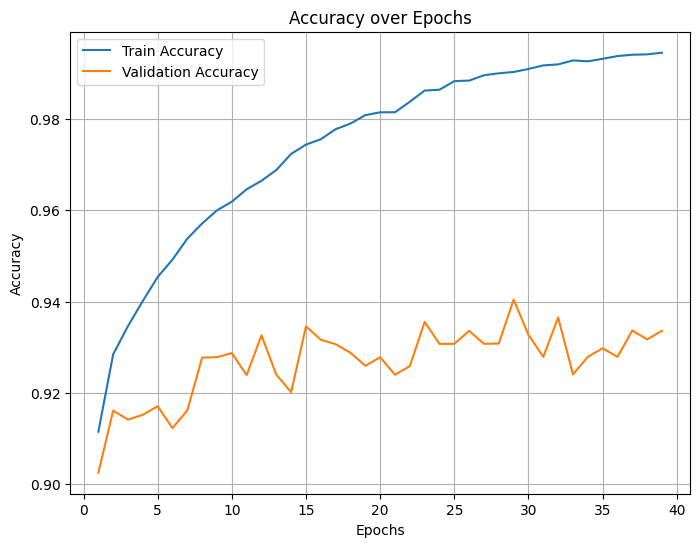

Best Train Accuracy: 0.9903293777255955, Best Validation Accuracy: 0.9404296875


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 310065.46it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 626/626 [00:00<00:00, 193203.41it/s]


start predict


10it [00:00, 108.76it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_monologg_koelectra-small-v3-discriminator_lr_1e-05_batch_64_epochs_50_maxlen_32_eps_1e-08_TrainAcc_0.9903293777255955_ValAcc_0.9404296875/submission.csv


In [10]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 64,
    "maxlen" : 32,
    "lr" : 1e-5,
    "eps" : 1e-8,
    "epochs" : 50,
    "model_ckpt" : "monologg/koelectra-small-v3-discriminator",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 64,
  "maxlen" : 32,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 221447.11it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 269074.82it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 973/973 [00:00<00:00, 86399.02it/s]


start training


training epoch 0: 100%|█████████████████████| 2981/2981 [02:39<00:00, 18.70it/s]


start predict


2981it [00:53, 56.04it/s]


start predict


16it [00:00, 57.85it/s]


Epoch 0,  Average training loss: 0.3468 , Train accuracy : 0.9316, Validation accuracy : 0.9025


training epoch 1: 100%|█████████████████████| 2981/2981 [02:39<00:00, 18.72it/s]


start predict


2981it [00:53, 55.87it/s]


start predict


16it [00:00, 59.95it/s]


Epoch 1,  Average training loss: 0.2133 , Train accuracy : 0.9450, Validation accuracy : 0.9171


training epoch 2: 100%|█████████████████████| 2981/2981 [02:39<00:00, 18.71it/s]


start predict


2981it [00:53, 55.88it/s]


start predict


16it [00:00, 59.64it/s]


Epoch 2,  Average training loss: 0.1826 , Train accuracy : 0.9528, Validation accuracy : 0.9190


training epoch 3: 100%|█████████████████████| 2981/2981 [02:39<00:00, 18.70it/s]


start predict


2981it [00:53, 55.85it/s]


start predict


16it [00:00, 59.45it/s]


Epoch 3,  Average training loss: 0.1616 , Train accuracy : 0.9606, Validation accuracy : 0.9191


training epoch 4: 100%|█████████████████████| 2981/2981 [02:39<00:00, 18.72it/s]


start predict


2981it [00:53, 55.82it/s]


start predict


16it [00:00, 59.30it/s]


Epoch 4,  Average training loss: 0.1440 , Train accuracy : 0.9681, Validation accuracy : 0.9249


training epoch 5: 100%|█████████████████████| 2981/2981 [02:39<00:00, 18.71it/s]


start predict


2981it [00:53, 55.82it/s]


start predict


16it [00:00, 59.82it/s]


Epoch 5,  Average training loss: 0.1296 , Train accuracy : 0.9719, Validation accuracy : 0.9191


training epoch 6: 100%|█████████████████████| 2981/2981 [02:39<00:00, 18.72it/s]


start predict


2981it [00:53, 55.87it/s]


start predict


16it [00:00, 59.96it/s]


Epoch 6,  Average training loss: 0.1162 , Train accuracy : 0.9773, Validation accuracy : 0.9191


training epoch 7: 100%|█████████████████████| 2981/2981 [02:39<00:00, 18.71it/s]


start predict


2981it [00:53, 55.86it/s]


start predict


16it [00:00, 59.69it/s]


Epoch 7,  Average training loss: 0.1048 , Train accuracy : 0.9809, Validation accuracy : 0.9268


training epoch 8: 100%|█████████████████████| 2981/2981 [02:39<00:00, 18.74it/s]


start predict


2981it [00:53, 55.87it/s]


start predict


16it [00:00, 59.77it/s]


Epoch 8,  Average training loss: 0.0959 , Train accuracy : 0.9845, Validation accuracy : 0.9239


training epoch 9: 100%|█████████████████████| 2981/2981 [02:39<00:00, 18.70it/s]


start predict


2981it [00:53, 55.77it/s]


start predict


16it [00:00, 59.75it/s]


Epoch 9,  Average training loss: 0.0854 , Train accuracy : 0.9877, Validation accuracy : 0.9268


training epoch 10: 100%|████████████████████| 2981/2981 [02:39<00:00, 18.71it/s]


start predict


2981it [00:53, 55.73it/s]


start predict


16it [00:00, 59.78it/s]


Epoch 10,  Average training loss: 0.0774 , Train accuracy : 0.9890, Validation accuracy : 0.9229


training epoch 11: 100%|████████████████████| 2981/2981 [02:39<00:00, 18.69it/s]


start predict


2981it [00:53, 55.72it/s]


start predict


16it [00:00, 59.88it/s]


Epoch 11,  Average training loss: 0.0709 , Train accuracy : 0.9914, Validation accuracy : 0.9238


training epoch 12: 100%|████████████████████| 2981/2981 [02:39<00:00, 18.69it/s]


start predict


2981it [00:53, 55.77it/s]


start predict


16it [00:00, 59.64it/s]


Epoch 12,  Average training loss: 0.0657 , Train accuracy : 0.9916, Validation accuracy : 0.9326


training epoch 13: 100%|████████████████████| 2981/2981 [02:39<00:00, 18.71it/s]


start predict


2981it [00:53, 55.70it/s]


start predict


16it [00:00, 59.53it/s]


Epoch 13,  Average training loss: 0.0589 , Train accuracy : 0.9946, Validation accuracy : 0.9249


training epoch 14: 100%|████████████████████| 2981/2981 [02:39<00:00, 18.68it/s]


start predict


2981it [00:53, 55.65it/s]


start predict


16it [00:00, 59.59it/s]


Epoch 14,  Average training loss: 0.0543 , Train accuracy : 0.9951, Validation accuracy : 0.9210


training epoch 15: 100%|████████████████████| 2981/2981 [02:39<00:00, 18.69it/s]


start predict


2981it [00:53, 55.65it/s]


start predict


16it [00:00, 59.46it/s]


Epoch 15,  Average training loss: 0.0507 , Train accuracy : 0.9962, Validation accuracy : 0.9316


training epoch 16: 100%|████████████████████| 2981/2981 [02:39<00:00, 18.67it/s]


start predict


2981it [00:53, 55.63it/s]


start predict


16it [00:00, 59.35it/s]


Epoch 16,  Average training loss: 0.0461 , Train accuracy : 0.9968, Validation accuracy : 0.9336


training epoch 17: 100%|████████████████████| 2981/2981 [02:39<00:00, 18.68it/s]


start predict


2981it [00:53, 55.55it/s]


start predict


16it [00:00, 59.55it/s]


Epoch 17,  Average training loss: 0.0429 , Train accuracy : 0.9975, Validation accuracy : 0.9317


training epoch 18: 100%|████████████████████| 2981/2981 [02:39<00:00, 18.68it/s]


start predict


2981it [00:53, 55.46it/s]


start predict


16it [00:00, 59.11it/s]


Epoch 18,  Average training loss: 0.0402 , Train accuracy : 0.9973, Validation accuracy : 0.9279


training epoch 19: 100%|████████████████████| 2981/2981 [02:39<00:00, 18.67it/s]


start predict


2981it [00:53, 55.47it/s]


start predict


16it [00:00, 59.17it/s]


Epoch 19,  Average training loss: 0.0373 , Train accuracy : 0.9978, Validation accuracy : 0.9298


training epoch 20: 100%|████████████████████| 2981/2981 [02:39<00:00, 18.67it/s]


start predict


2981it [00:53, 55.42it/s]


start predict


16it [00:00, 59.71it/s]


Epoch 20,  Average training loss: 0.0359 , Train accuracy : 0.9984, Validation accuracy : 0.9259


training epoch 21: 100%|████████████████████| 2981/2981 [02:39<00:00, 18.65it/s]


start predict


2981it [00:53, 55.39it/s]


start predict


16it [00:00, 59.50it/s]


Epoch 21,  Average training loss: 0.0329 , Train accuracy : 0.9983, Validation accuracy : 0.9288


training epoch 22: 100%|████████████████████| 2981/2981 [02:39<00:00, 18.65it/s]


start predict


2981it [00:53, 55.39it/s]


start predict


16it [00:00, 59.27it/s]


Epoch 22,  Average training loss: 0.0302 , Train accuracy : 0.9986, Validation accuracy : 0.9297


training epoch 23: 100%|████████████████████| 2981/2981 [02:39<00:00, 18.66it/s]


start predict


2981it [00:53, 55.34it/s]


start predict


16it [00:00, 59.38it/s]


Epoch 23,  Average training loss: 0.0291 , Train accuracy : 0.9989, Validation accuracy : 0.9259


training epoch 24: 100%|████████████████████| 2981/2981 [02:39<00:00, 18.65it/s]


start predict


2981it [00:53, 55.37it/s]


start predict


16it [00:00, 59.40it/s]


Epoch 24,  Average training loss: 0.0267 , Train accuracy : 0.9989, Validation accuracy : 0.9229


training epoch 25: 100%|████████████████████| 2981/2981 [02:39<00:00, 18.65it/s]


start predict


2981it [00:53, 55.34it/s]


start predict


16it [00:00, 59.17it/s]


Epoch 25,  Average training loss: 0.0256 , Train accuracy : 0.9991, Validation accuracy : 0.9258


training epoch 26: 100%|████████████████████| 2981/2981 [02:39<00:00, 18.65it/s]


start predict


2981it [00:53, 55.30it/s]


start predict


16it [00:00, 58.86it/s]


Epoch 26,  Average training loss: 0.0227 , Train accuracy : 0.9992, Validation accuracy : 0.9229
[Early Stopping]10 epoch에서 중단.[Early Stopping]


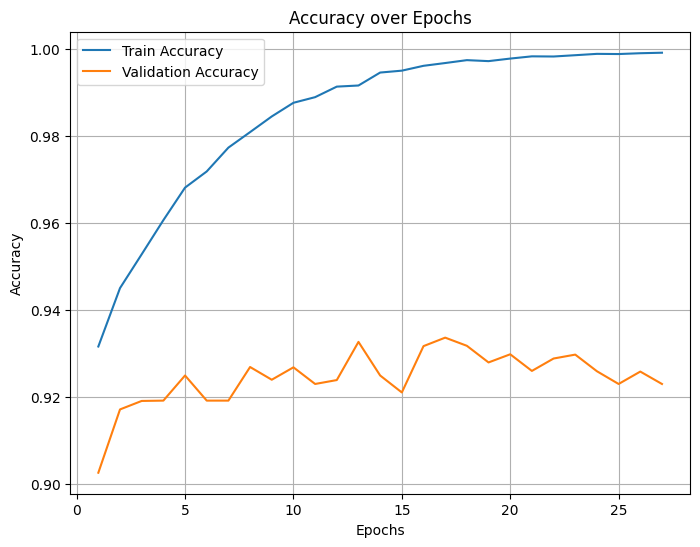

Best Train Accuracy: 0.9968183914793693, Best Validation Accuracy: 0.93359375


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 237656.98it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 626/626 [00:00<00:00, 88796.86it/s]


start predict


10it [00:00, 58.88it/s]


Submission file saved to ./saved_checkpoints/best_model/model_ckpt_monologg_koelectra-small-v3-discriminator_lr_3e-05_batch_64_epochs_50_maxlen_64_eps_1e-08_TrainAcc_0.9968183914793693_ValAcc_0.93359375/submission.csv


In [8]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 64,
    "maxlen" : 64,
    "lr" : 3e-5,
    "eps" : 1e-8,
    "epochs" : 50,
    "model_ckpt" : "monologg/koelectra-small-v3-discriminator",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 64,
  "maxlen" : 64,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 223037.09it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 269911.23it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 157357.15it/s]


start training


training epoch 0: 100%|█████████████████████| 2981/2981 [01:35<00:00, 31.11it/s]


start predict


2981it [00:29, 101.29it/s]


start predict


16it [00:00, 107.34it/s]


Epoch 0,  Average training loss: 0.3826 , Train accuracy : 0.9308, Validation accuracy : 0.9064


training epoch 1: 100%|█████████████████████| 2981/2981 [01:36<00:00, 31.02it/s]


start predict


2981it [00:29, 100.81it/s]


start predict


16it [00:00, 107.27it/s]


Epoch 1,  Average training loss: 0.2169 , Train accuracy : 0.9447, Validation accuracy : 0.9249


training epoch 2: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.97it/s]


start predict


2981it [00:29, 100.67it/s]


start predict


16it [00:00, 106.13it/s]


Epoch 2,  Average training loss: 0.1850 , Train accuracy : 0.9532, Validation accuracy : 0.9239


training epoch 3: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.94it/s]


start predict


2981it [00:29, 100.95it/s]


start predict


16it [00:00, 107.27it/s]


Epoch 3,  Average training loss: 0.1634 , Train accuracy : 0.9604, Validation accuracy : 0.9298


training epoch 4: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.94it/s]


start predict


2981it [00:29, 100.89it/s]


start predict


16it [00:00, 106.81it/s]


Epoch 4,  Average training loss: 0.1466 , Train accuracy : 0.9663, Validation accuracy : 0.9229


training epoch 5: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.92it/s]


start predict


2981it [00:29, 100.72it/s]


start predict


16it [00:00, 106.99it/s]


Epoch 5,  Average training loss: 0.1308 , Train accuracy : 0.9717, Validation accuracy : 0.9307


training epoch 6: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.95it/s]


start predict


2981it [00:29, 100.41it/s]


start predict


16it [00:00, 106.00it/s]


Epoch 6,  Average training loss: 0.1173 , Train accuracy : 0.9766, Validation accuracy : 0.9259


training epoch 7: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.93it/s]


start predict


2981it [00:29, 100.94it/s]


start predict


16it [00:00, 102.08it/s]


Epoch 7,  Average training loss: 0.1063 , Train accuracy : 0.9806, Validation accuracy : 0.9248


training epoch 8: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.96it/s]


start predict


2981it [00:29, 100.94it/s]


start predict


16it [00:00, 106.56it/s]


Epoch 8,  Average training loss: 0.0958 , Train accuracy : 0.9854, Validation accuracy : 0.9230


training epoch 9: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.95it/s]


start predict


2981it [00:29, 100.83it/s]


start predict


16it [00:00, 107.03it/s]


Epoch 9,  Average training loss: 0.0868 , Train accuracy : 0.9871, Validation accuracy : 0.9287


training epoch 10: 100%|████████████████████| 2981/2981 [01:36<00:00, 30.97it/s]


start predict


2981it [00:29, 100.75it/s]


start predict


16it [00:00, 107.14it/s]


Epoch 10,  Average training loss: 0.0775 , Train accuracy : 0.9897, Validation accuracy : 0.9346


training epoch 11: 100%|████████████████████| 2981/2981 [01:36<00:00, 30.98it/s]


start predict


2981it [00:29, 100.81it/s]


start predict


16it [00:00, 106.28it/s]


Epoch 11,  Average training loss: 0.0704 , Train accuracy : 0.9914, Validation accuracy : 0.9346


training epoch 12: 100%|████████████████████| 2981/2981 [01:36<00:00, 30.86it/s]


start predict


2981it [00:29, 100.81it/s]


start predict


16it [00:00, 105.32it/s]


Epoch 12,  Average training loss: 0.0640 , Train accuracy : 0.9939, Validation accuracy : 0.9229


training epoch 13: 100%|████████████████████| 2981/2981 [01:36<00:00, 30.92it/s]


start predict


2981it [00:29, 100.89it/s]


start predict


16it [00:00, 105.46it/s]


Epoch 13,  Average training loss: 0.0580 , Train accuracy : 0.9946, Validation accuracy : 0.9289


training epoch 14: 100%|████████████████████| 2981/2981 [01:36<00:00, 30.96it/s]


start predict


2981it [00:29, 100.83it/s]


start predict


16it [00:00, 107.02it/s]


Epoch 14,  Average training loss: 0.0539 , Train accuracy : 0.9949, Validation accuracy : 0.9258


training epoch 15: 100%|████████████████████| 2981/2981 [01:36<00:00, 30.97it/s]


start predict


2981it [00:29, 100.71it/s]


start predict


16it [00:00, 105.72it/s]


Epoch 15,  Average training loss: 0.0499 , Train accuracy : 0.9960, Validation accuracy : 0.9316


training epoch 16: 100%|████████████████████| 2981/2981 [01:36<00:00, 30.96it/s]


start predict


2981it [00:29, 100.84it/s]


start predict


16it [00:00, 104.87it/s]


Epoch 16,  Average training loss: 0.0465 , Train accuracy : 0.9972, Validation accuracy : 0.9297


training epoch 17: 100%|████████████████████| 2981/2981 [01:36<00:00, 30.89it/s]


start predict


2981it [00:29, 100.77it/s]


start predict


16it [00:00, 106.66it/s]


Epoch 17,  Average training loss: 0.0427 , Train accuracy : 0.9973, Validation accuracy : 0.9259


training epoch 18: 100%|████████████████████| 2981/2981 [01:36<00:00, 30.91it/s]


start predict


2981it [00:29, 100.54it/s]


start predict


16it [00:00, 106.58it/s]


Epoch 18,  Average training loss: 0.0396 , Train accuracy : 0.9979, Validation accuracy : 0.9250


training epoch 19: 100%|████████████████████| 2981/2981 [01:36<00:00, 30.93it/s]


start predict


2981it [00:29, 100.44it/s]


start predict


16it [00:00, 106.13it/s]


Epoch 19,  Average training loss: 0.0368 , Train accuracy : 0.9980, Validation accuracy : 0.9268


training epoch 20: 100%|████████████████████| 2981/2981 [01:36<00:00, 30.93it/s]


start predict


2981it [00:29, 100.56it/s]


start predict


16it [00:00, 105.06it/s]


Epoch 20,  Average training loss: 0.0358 , Train accuracy : 0.9981, Validation accuracy : 0.9288
[Early Stopping]10 epoch에서 중단.[Early Stopping]


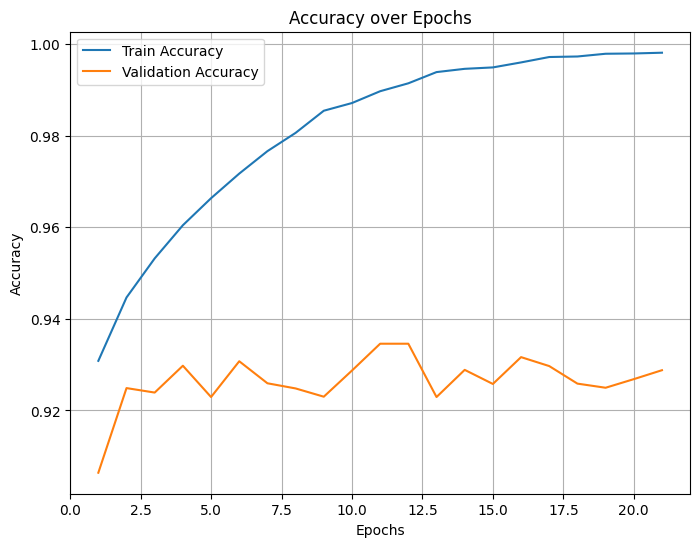

Best Train Accuracy: 0.9897056356927205, Best Validation Accuracy: 0.9345703125


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 151455.60it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 626/626 [00:00<00:00, 87331.92it/s]


start predict


10it [00:00, 58.19it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_monologg_koelectra-small-v3-discriminator_lr_3e-05_batch_64_epochs_100_maxlen_32_eps_1e-08_TrainAcc_0.9897056356927205_ValAcc_0.9345703125/submission.csv


In [12]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 64,
    "maxlen" : 32,
    "lr" : 3e-5,
    "eps" : 1e-8,
    "epochs" : 100,
    "model_ckpt" : "monologg/koelectra-small-v3-discriminator",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 64,
  "maxlen" : 64,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)